## Summary overview | SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model)

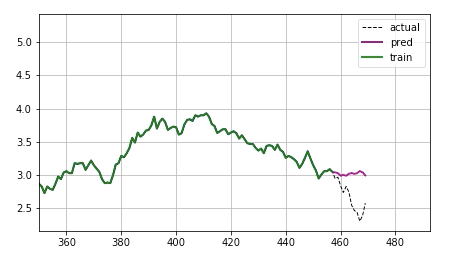

In [1]:
from IPython.display import Image
Image(filename='images/sarimax_snake.gif.png')

In [2]:
# general import environment
print('versions')
print ('------------')
import pandas as pd
print('pandas: ', pd.__version__)
pd.set_option('display.max_columns', None)

import numpy as np
print('numpy: ', np.__version__)

import time as time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
print('mpl: ', mpl.__version__)
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore") # ignore warnings

versions
------------
pandas:  0.20.3
numpy:  1.13.3
mpl:  2.0.2


### load cached data

In [3]:
#### cache during development
temporal_group = 'weekly'
df = pd.read_csv('data/historical_data_{0}.csv'.format(temporal_group))

In [4]:
# force convert string dates to dt objects
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
# identify single columns to target
target_column = 'DGS30'

### timeseries decomposition

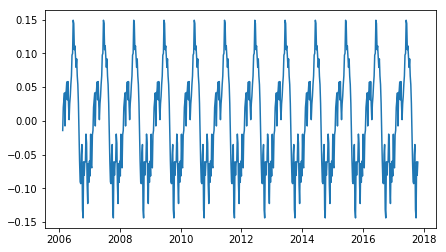

In [6]:
import statsmodels.api as sm
mpl.rc('figure', figsize=(7, 4))
sdecomp = pd.DataFrame()
sdecomp[target_column] = df[target_column]
res = sm.tsa.seasonal_decompose(sdecomp)
# resplot = res.plot()
plt.plot(res.seasonal[target_column])
plt.show;

### train SARIMAX model

In [7]:
import statsmodels.api as sm

#### create grid-search params

In [8]:
import itertools
# define order params, generate combinatorial pairings
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('[seasonal ARIMA]')
print('=-=-=--=-=-=-==-=-=-=-=-==-=-=-=-=')
print('sarimax: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('sarimax: {} x {}'.format(pdq[5], seasonal_pdq[4]))
print('sarimax: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('sarimax: {} x {}'.format(pdq[0], seasonal_pdq[5]))

[seasonal ARIMA]
=-=-=--=-=-=-==-=-=-=-=-==-=-=-=-=
sarimax: (0, 0, 1) x (0, 0, 1, 12)
sarimax: (1, 0, 1) x (1, 0, 0, 12)
sarimax: (0, 1, 0) x (0, 1, 1, 12)
sarimax: (0, 0, 0) x (1, 0, 1, 12)


In [18]:
# set baseline data:
y = df[target_column].values

alist, blist, clist, dlist, elist = ([] for i in range(5))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            alist.append(param)
            blist.append(results.aic)
            clist.append(results.bic)
            dlist.append(sum((results.fittedvalues-y)**2))

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [10]:
results_df = pd.DataFrame({'params':alist,'aic':blist,'bic':clist,'rss':dlist})
results_df = results_df.sort_values(['rss','aic'],ascending=True)

In [11]:
results_df.head(5)

,aic,bic,params,rss
36,-1132.011291,-1118.766000,"(1, 0, 1)",26.025783
40,-1107.660838,-1090.000450,"(1, 0, 1)",26.033444
20,-1130.559819,-1121.729625,"(0, 1, 1)",26.034340
24,-1107.900513,-1094.655222,"(0, 1, 1)",26.039391
21,-1102.360534,-1089.115243,"(0, 1, 1)",26.040570


In [12]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(4, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
# print(results.summary().tables[1])

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  611
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 522.681
Date:                            Tue, 17 Oct 2017   AIC                          -1029.362
Time:                                    15:08:12   BIC                           -994.042
Sample:                                         0   HQIC                         -1015.624
                                            - 611                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4776      0.347     -1.375      0.169      -1.158       0.203
ar.L2          0.1192      0.067      1.790      0.073      -0.011       0.250
ar.L3          0.0258      0.039      0.662      0.508      -0.051       0.102
ar.L4          0.0564      0.038      1.494      0.135      -0.018       0.130
ma.L1          0.6255      0.350      1.786      0.074      -0.061       1.312
ar.S.L12      -0.0336      0.040     -0.833      0.405      -0.113       0.045
ma.S.L12      -0.9648      0.035    -27.250      0.000      -1.034      -0.895
sigma2         0.0092      0.000     19.673      0.000       0.008       0.010
===================================================================================
Ljung-Box (Q):                       36.63   Jarque-Bera (JB):                32.41
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

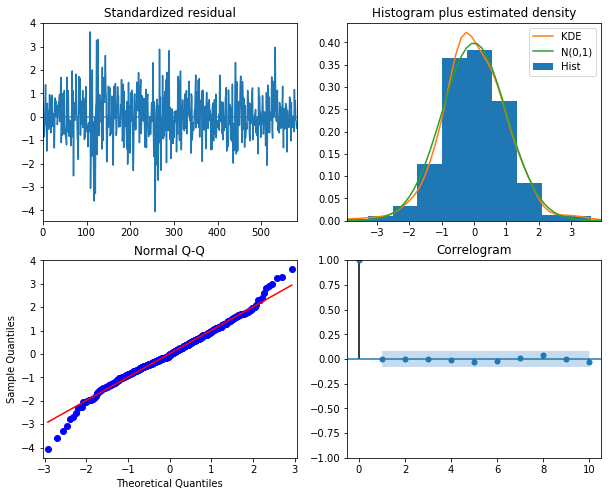

In [14]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

In [15]:
# pred = results.get_prediction(start=pd.to_datetime(forecast_period_start), dynamic=False)
pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

print(len(list(pred.predicted_mean)))
print(len(y))

611
611


In [16]:
cutoff_pt = 65
flist = list(y[:-cutoff_pt]) + list(pred.predicted_mean[-cutoff_pt:])

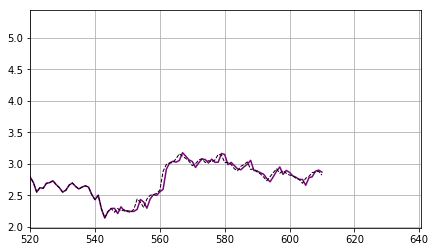

In [17]:
plt.plot(flist,c='purple',lw=1.5)
plt.plot(list(y),linestyle='--',lw=1,c='k')
plt.grid(True)
plt.xlim(len(y)-cutoff_pt*1.4)
plt.show;